In [105]:
# Import necessary package here.
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, ifft
import struct 

# Configure plot universal property
plt.rcParams['figure.figsize'] = (12,10)
plt.rcParams['font.size'] = 16

%matplotlib inline

data_dir = './Data/Data_ex2'

In [2]:
#Define Constants

R0 = 1000 #closest range, (m)
v = 70    #sensor velocity (m/s)
L_antenna = 2  #antenna length (m)

lamda = 0.0566 #wavelength
C = 3e8    #speed of light (m/s)
Bw = 50e6  #bandwidth (Hz)
Tau = 5e-6 #pulse width (s)
Fs_range = 100e6  #sampling frequency in range (Hz)
PRF = 400  #pulse repetition frequency (Hz)

omega = 2 * np.pi * Fs_range
t = np.arange(-Tau/2, Tau/2, 1/Fs_range)
beta = Bw / Tau

In [3]:
def open_dat_file(path: str) -> np.ndarray:
    print(f"Opening file: {path}")
    with open(path, 'rb') as rfile:
        rng = struct.unpack('>l', rfile.read(4))[0]
        azm = struct.unpack('>l', rfile.read(4))[0]
        print(f" - Range:   {rng}")
        print(f" - Azimuth: {azm}")
        dt = np.dtype('>c8')
        arr = np.fromfile(rfile, dtype=dt)
    return arr.reshape((azm, rng))

def matched_filter(t, omega, beta, tau):
#     x = (- np.pi*beta*t)*t
#     s = np.exp(1j * x[:, np.newaxis])
    s = np.conj(np.flip(np.exp(-1j * np.pi*beta/t**2)))
    s[np.where(np.abs(t) >= tau/2)] = 0  
    return s

def hamming_window(t, alpha, tau):
    w = -(alpha - 1) * np.cos(2*np.pi*t/tau) + alpha
    w[np.where(np.abs(t) >= tau/2)] = 0
    return w

In [4]:
t.shape

(501,)

A radar image represents two-dimensional data. This requires not only focusing in range (see first exercise) but also focusing in azimuth (= along track, i.e. in the flight direction of the sensor). You will find the formulas required for the range and azimuth chirp rates in the tutorial on epsilon nought (http://epsilon.nought.de/).

# 2.1 2D Chirp (point source)
Use the information in the file [chirp 2d test constants.txt] and [chirp 2d test.dat] to focus (or compress) the 2-D radar raw data. The image represent the raw-format of radar data of a single strong scatterer. After focusing in range an azimuth, the image still consists of complex values. This data format is called single-look-complex or SLC. Most radar data is distributed in the SLC format.

*Definition of the .DAT format: * 

two LONG values representing the number of pixels in range and azimuth direction. Then follows a sequence of complex values which represent a 2D matrix of the dimension given by range and azimuth. Write a binary-reader function to import the data. When you visualize the data, you should see several rings. (IDL functions that may help: openr, readu, close, free lun, lonarr, complexarr, shade surf)

### Tasks: 

1. compress the 2D raw data: 
    Plot intensity and phase of the compressed image.
2. compress the 2D raw data using an Hamming filter in azimuth: 
    Visualize the intensity and phase of the compressed image.
3. compress the 2D raw data using two looks in the azimuth spectrum: 
    Split the azimuth-spectrum and focus both spectra independently. Then average the magnitude of both images. 
    
**Literature: Chapter 2.2 in the ”Scientific SAR User’s Guide” by Coert Olmsted.**

In [55]:
test_img = open_dat_file(data_dir+'/chirp_2d_test.dat')
n_azi, n_rg = test_img.shape

Opening file: ./Data/Data_ex2/chirp_2d_test.dat
 - Range:   512
 - Azimuth: 1081


In [120]:
h = np.conj(np.flip(np.exp(-1j * np.pi*Bw/Tau*t**2)))
ref_r = np.zeros([1, n_rg], dtype=np.complex_)
idx = round((n_rg - h.shape[0])/2) + np.arange(h.shape[0])
ref_r[0, idx] = h
# ref_r = np.roll(ref_r, round(n_rg/2)) 

In [121]:
from scipy import signal
comp_img = np.zeros_like(test_img, dtype=np.complex_)
for i in range(test_img.shape[0]):
    comp_img[i,:] = signal.fftconvolve(test_img[i,:].astype(np.complex_).flatten(), ref_r.flatten()*n_rg, 'same')

In [114]:
comp_img = np.zeros_like(test_img, dtype=np.complex_)
for i in range(test_img.shape[0]):
    comp_img[i,:] = np.convolve(test_img[i,:].flatten(), ref_r.flatten()*n_rg, 'same')
#     comp_img[i, :] = ifft(fft(test_img[i, :].astype(np.complex_)) * fft(ref_r)*n_rg)

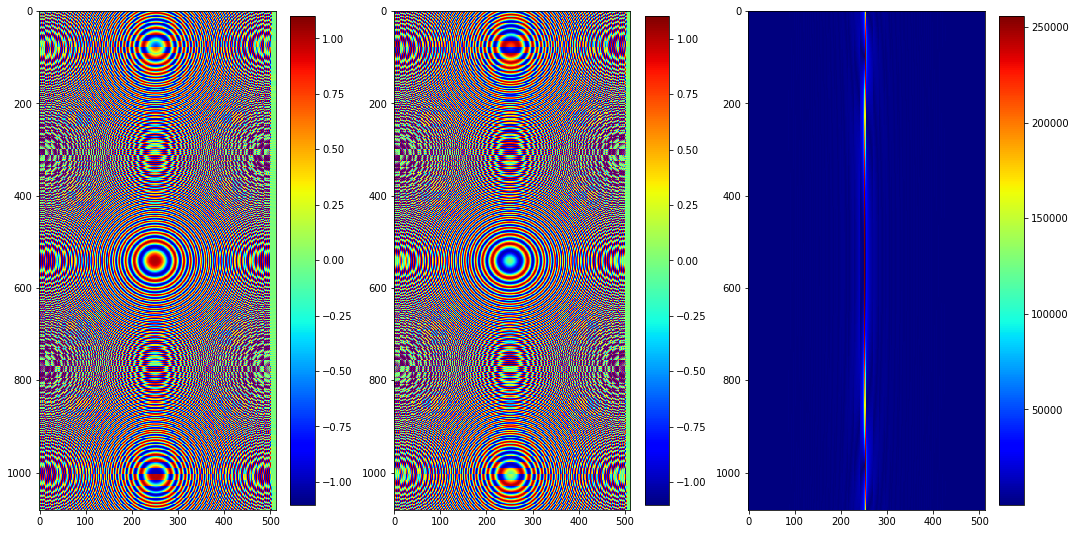

In [122]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(131)
real_part = ax1.imshow(np.real(test_img), cmap='jet')
fig.colorbar(real_part, ax=ax1, shrink=0.9)
# cbar1 = fig.colorbar(real_part)

ax2 = fig.add_subplot(132)
imag_part = ax2.imshow(np.imag(test_img), cmap='jet')
fig.colorbar(imag_part, ax=ax2, shrink=0.9)

ax3 = fig.add_subplot(133)
rg_focus = ax3.imshow(np.abs(comp_img), cmap='jet')
cbar = fig.colorbar(rg_focus, ax=ax3, shrink=0.9, )
# cbar.set_clim(-0.4e8, 0.8e8)

plt.show()

In [ ]:
def compress_image(img, axis, h, hw=None):
    if type(axis) == list:
        signal = img[axis[0], axis[1]]
    elif type(axis) == int:
        signal = img[axis]
    else:
        raise TypeError('Axis value is illegal')
        
    signal_f = fft(signal)
    
    h_f = fft(h)
    
    if hw not None:
        hh = h.flatten() * hw
    
    